In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, LearningCurveDisplay, ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
import joblib
import pickle
import matplotlib.pyplot as plt
from mlxtend.evaluate import bias_variance_decomp

# Implement different classifiers, take majority vote, aka: **Bagging**

In [2]:
df = pd.read_csv('../body_level_classification_train.csv')
df.Body_Level.value_counts()

Body_Level
Body Level 4    680
Body Level 3    406
Body Level 2    201
Body Level 1    190
Name: count, dtype: int64

### Some Preprocessing


In [3]:
df.head()

,Gender,Age,Height,Weight,H_Cal_Consump,Veg_Consump,Water_Consump,Alcohol_Consump,Smoking,Meal_Count,Food_Between_Meals,Fam_Hist,H_Cal_Burn,Phys_Act,Time_E_Dev,Transport,Body_Level
0,Female,22.547298,1.722461,51.881263,yes,2.663421,1.041110,no,no,3.000000,Frequently,yes,no,0.794402,1.391948,Public_Transportation,Body Level 1
1,Male,19.799054,1.743702,54.927529,yes,2.000000,2.847264,Sometimes,no,3.289260,Sometimes,yes,no,1.680844,2.000000,Public_Transportation,Body Level 1
2,Female,17.823438,1.708406,50.000000,yes,1.642241,1.099231,Sometimes,no,3.452590,Sometimes,no,no,0.418875,1.000000,Public_Transportation,Body Level 1
3,Female,19.007177,1.690727,49.895716,yes,1.212908,1.029703,Sometimes,no,3.207071,Sometimes,no,no,2.000000,1.000000,Public_Transportation,Body Level 1
4,Male,19.729250,1.793315,58.195150,yes,2.508835,2.076933,no,no,3.435905,Sometimes,yes,no,2.026668,1.443328,Automobile,Body Level 1


In [4]:
print(df.Alcohol_Consump.unique())
print(df.Smoking.unique())
print(df.Food_Between_Meals.unique())
print(df.Fam_Hist.unique())
print(df.H_Cal_Burn.unique())
print(df.Body_Level.unique())
print(df.Transport.unique())

['no' 'Sometimes' 'Frequently' 'Always']
['no' 'yes']
['Frequently' 'Sometimes' 'no' 'Always']
['yes' 'no']
['no' 'yes']
['Body Level 1' 'Body Level 2' 'Body Level 3' 'Body Level 4']
['Public_Transportation' 'Automobile' 'Walking' 'Bike' 'Motorbike']


In [5]:
def AdaBoostPreprocessor(df, inference=False, add_Custom_Features=True):
    df.loc[df["Gender"]=="Male", 'Gender'] = True
    df.loc[df["Gender"]=="Female", 'Gender'] = False
    df.loc[df["H_Cal_Consump"]=="yes", 'H_Cal_Consump'] = True
    df.loc[df["H_Cal_Consump"]=="no", 'H_Cal_Consump'] = False
    ListAlcoholConsump = ['no', 'Sometimes', 'Frequently', 'Always']
    df['Alcohol_Consump']=df['Alcohol_Consump'].apply(lambda x: ListAlcoholConsump.index(str(x)))
    df.loc[df["Smoking"]=="yes", 'Smoking'] = True
    df.loc[df["Smoking"]=="no", 'Smoking'] = False
    df['Food_Between_Meals']=df['Food_Between_Meals'].apply(lambda x: ListAlcoholConsump.index(str(x)))
    df.loc[df["Fam_Hist"]=="yes", 'Fam_Hist'] = True
    df.loc[df["Fam_Hist"]=="no", 'Fam_Hist'] = False
    df.loc[df["H_Cal_Burn"]=="yes", 'H_Cal_Burn'] = True
    df.loc[df["H_Cal_Burn"]=="no", 'H_Cal_Burn'] = False
    #df['Transport'] = LabelEncoder().fit_transform(df['Transport'])
    ListTransport = ['Public_Transportation', 'Automobile', 'Walking', 'Bike', 'Motorbike']
    df['Transport'] = df['Transport'].apply(lambda x: ListTransport.index(str(x)))

    if(not inference):
      #df['Body_Level'] = LabelEncoder().fit_transform(df['Body_Level'])
      ListBodyLevel = ['Body Level 1', 'Body Level 2', 'Body Level 3', 'Body Level 4']
      df['Body_Level'] = df['Body_Level'].apply(lambda x: ListBodyLevel.index(str(x)) + 1)
      y=df['Body_Level']

    if(add_Custom_Features):
      bmi=df['Weight']/(df['Height']**2)
      df['bmi'] = bmi
      y0=bmi*0
      y0[bmi>29.9]=4
      y0[bmi<=29.9]=3
      y0[bmi<=24.9]=2
      y0[bmi<18.5]=1

    return df
    
def AdaBoostSMOTE(df):
    oversample = SMOTE()
    y=df['Body_Level']
    X=df.loc[:, df.columns != 'Body_Level']

    X0, y = oversample.fit_resample(X, y)
    df = X0
    df['Body_Level'] = y
    return df


In [6]:
df = AdaBoostPreprocessor(df).copy()
df = AdaBoostSMOTE(df).copy()
df.describe()

,Age,Height,Weight,Veg_Consump,Water_Consump,Alcohol_Consump,Meal_Count,Food_Between_Meals,Phys_Act,Time_E_Dev,Transport,bmi,Body_Level
count,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.00000
mean,23.026751,1.693686,74.703367,2.400588,1.947649,0.626838,2.720611,1.171691,1.086986,0.669819,0.270588,25.842022,2.50000
std,5.784530,0.095934,24.963751,0.531679,0.602637,0.530164,0.816933,0.493734,0.831031,0.604581,0.555440,7.681775,1.11824
min,15.000000,1.456346,39.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.291588,1.00000
25%,19.002284,1.620000,54.255560,2.000000,1.456767,0.000000,2.604167,1.000000,0.319946,0.007783,0.000000,18.560775,1.75000
50%,21.305392,1.699982,70.000000,2.388956,2.000000,1.000000,3.000000,1.000000,1.000000,0.637924,0.000000,24.681613,2.50000
75%,25.000000,1.761168,87.078964,2.994487,2.364934,1.000000,3.000000,1.000000,1.873706,1.000000,0.000000,30.125555,3.25000
max,55.246250,1.980000,173.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,2.000000,4.000000,50.811753,4.00000


In [7]:
df.isna().sum()

Gender                0
Age                   0
Height                0
Weight                0
H_Cal_Consump         0
Veg_Consump           0
Water_Consump         0
Alcohol_Consump       0
Smoking               0
Meal_Count            0
Food_Between_Meals    0
Fam_Hist              0
H_Cal_Burn            0
Phys_Act              0
Time_E_Dev            0
Transport             0
bmi                   0
Body_Level            0
dtype: int64

In [8]:
'''
df_no_outliers = df.loc[:, ['Age',	'Height',	'Weight'	,'Veg_Consump'	,'Water_Consump','Meal_Count',	'H_Cal_Burn',	'Phys_Act',	'Time_E_Dev']]
df_no_outliers = df_no_outliers.astype(np.float64)
df_no_outliers.sc

data_mean, data_std = df_no_outliers.mean(), df_no_outliers.std()
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
print(lower)
# identify outliers
outliers = [x for x in df_no_outliers if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in df_no_outliers if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))
'''

"\ndf_no_outliers = df.loc[:, ['Age',\t'Height',\t'Weight'\t,'Veg_Consump'\t,'Water_Consump','Meal_Count',\t'H_Cal_Burn',\t'Phys_Act',\t'Time_E_Dev']]\ndf_no_outliers = df_no_outliers.astype(np.float64)\ndf_no_outliers.sc\n\ndata_mean, data_std = df_no_outliers.mean(), df_no_outliers.std()\n# identify outliers\ncut_off = data_std * 3\nlower, upper = data_mean - cut_off, data_mean + cut_off\nprint(lower)\n# identify outliers\noutliers = [x for x in df_no_outliers if x < lower or x > upper]\nprint('Identified outliers: %d' % len(outliers))\n# remove outliers\noutliers_removed = [x for x in df_no_outliers if x >= lower and x <= upper]\nprint('Non-outlier observations: %d' % len(outliers_removed))\n"

## Using Decision Tree Classifier, with 'entropy' criterion

In [9]:
#numeric_columns = ['Age',	'Height',	'Weight'	,'Veg_Consump'	,'Water_Consump','Meal_Count',	'H_Cal_Burn',	'Phys_Act',	'Time_E_Dev']

trainDF = df.loc[:,df.columns != 'Body_Level']
labelDF = df['Body_Level']
trainData_not_scaled = trainDF
trainData_scaled = StandardScaler().fit_transform(trainDF)

X_train, X_test, Y_train, Y_test = train_test_split(trainData_not_scaled , labelDF, test_size = 0.3, shuffle=True)
DecTree = DecisionTreeClassifier(criterion = 'entropy')
scores = cross_val_score(DecTree, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Decision Tree without scaling is {scores.mean()}")

X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.3, shuffle=True)
DecTree = DecisionTreeClassifier(criterion = 'entropy')
scores = cross_val_score(DecTree, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Decision Tree with scaling is {scores.mean()}")

mean scores using a Decision Tree without scaling is 0.9900015117787546
mean scores using a Decision Tree with scaling is 0.99107547711593


## same Decision Tree but using Bagging

In [10]:
bag = BaggingClassifier(estimator= DecisionTreeClassifier(criterion='entropy'), n_estimators=100, oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.3, shuffle=True)
scores = cross_val_score(bag, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Bagged Decision Tree with scaling is {scores.mean()}")
bag.fit(X_train, Y_train)
print(classification_report(Y_test, bag.predict(X_test)))

mean scores using a Bagged Decision Tree with scaling is 0.9937026601300522
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       208
           2       0.99      0.99      0.99       184
           3       1.00      1.00      1.00       224
           4       1.00      1.00      1.00       200

    accuracy                           1.00       816
   macro avg       1.00      1.00      1.00       816
weighted avg       1.00      1.00      1.00       816



## Using Random forest with scaling

In [11]:
RF = RandomForestClassifier(criterion='entropy')
X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.3, shuffle=True)
scores = cross_val_score(RF, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Random Forest with scaling is {scores.mean()}")
RF.fit(X_train, Y_train)
print(classification_report(Y_test,RF.predict(X_test)))

mean scores using a Random Forest with scaling is 0.9973738132090995
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       211
           2       0.99      1.00      1.00       219
           3       0.99      0.99      0.99       196
           4       0.99      0.99      0.99       190

    accuracy                           0.99       816
   macro avg       0.99      0.99      0.99       816
weighted avg       0.99      0.99      0.99       816



In [12]:
'''
playbag = BaggingClassifier(estimator= RandomForestClassifier(criterion='entropy'), n_estimators=100, oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.3, shuffle=True)
scores = cross_val_score(playbag, X_train, Y_train, cv=10)
print(f"mean scores using a Bagged Random Forest with scaling is {scores.mean()}")
'''

'\nplaybag = BaggingClassifier(estimator= RandomForestClassifier(criterion=\'entropy\'), n_estimators=100, oob_score=True)\nX_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.3, shuffle=True)\nscores = cross_val_score(playbag, X_train, Y_train, cv=10)\nprint(f"mean scores using a Bagged Random Forest with scaling is {scores.mean()}")\n'

## Same Decision tree and random forest, but using specific Columns, not all of them

In [13]:
#numeric_columns = ['Age',	'Height',	'Weight'	,'Veg_Consump'	,'Water_Consump','Meal_Count',	'H_Cal_Burn',	'Phys_Act',	'Time_E_Dev']
trainDF = df.loc[:,['bmi', 'Fam_Hist', 'Food_Between_Meals', 'Weight', 'Height', 'Age']]
labelDF = df['Body_Level']
trainData_not_scaled = trainDF
trainData_scaled = StandardScaler().fit_transform(trainDF)

X_train, X_test, Y_train, Y_test = train_test_split(trainData_not_scaled , labelDF, test_size = 0.3, shuffle=True)
DecTree = DecisionTreeClassifier(criterion = 'entropy')
scores = cross_val_score(DecTree, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Decision Tree without scaling using SPECIFIC FEATURES is {scores.mean()}")

X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.3, shuffle=True)
DecTree = DecisionTreeClassifier(criterion = 'entropy')
scores = cross_val_score(DecTree, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Decision Tree with scaling using SPECIFIC FEATURES is {scores.mean()}")

mean scores using a Decision Tree without scaling using SPECIFIC FEATURES is 0.9910731616700381
mean scores using a Decision Tree with scaling using SPECIFIC FEATURES is 0.9915949592447264


In [14]:
bag = BaggingClassifier(estimator= DecisionTreeClassifier(criterion='entropy'), n_estimators=100, oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.3, shuffle=True)
scores = cross_val_score(bag, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Bagged Decision Tree with scaling using SPECIFIC FEATURES is {scores.mean()}")
bag.fit(X_train, Y_train)
print(classification_report(Y_test,bag.predict(X_test)))

mean scores using a Bagged Decision Tree with scaling using SPECIFIC FEATURES is 0.9931765488236068
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       201
           2       0.98      1.00      0.99       212
           3       1.00      0.99      0.99       204
           4       1.00      1.00      1.00       199

    accuracy                           0.99       816
   macro avg       0.99      0.99      0.99       816
weighted avg       0.99      0.99      0.99       816



## Trying to remove some outliers (top and bottom 10%) from each class, in a trial to remove noise (misclassified data)

In [15]:
df1 = df.loc[df['Body_Level']==1, :]
df2 = df.loc[df['Body_Level']==2, :]
df3 = df.loc[df['Body_Level']==3, :]
df4 = df.loc[df['Body_Level']==4, :]

def RemoveTopBottomOutliers (df, columns):
  for column in columns:
    q_low = df[column].quantile(0.1)
    q_hi  = df[column].quantile(0.9)
    df_dummy = df.loc[(df[column] > q_hi) & (df[column] < q_low),:]
    #print(f"for Column {column}, found and removed {len(df_dummy)} outliers")
    df_filtered = df.loc[(df[column] < q_hi) & (df[column] > q_low), :]
  '''
  different_columns = [item for item in list(df.columns) if item not in columns]
  for col in different_columns:
    df_filtered[col] = df[col]
  df_filtered.dropna()
  '''
  print(f"size before : {len(df)}   size after : {len(df_filtered)}     removed {len(df) - len(df_filtered)} outliers")
  return df_filtered

numeric_columns = ['Age',	'Height',	'Weight'	,'Veg_Consump'	,'Water_Consump','Meal_Count',	'H_Cal_Burn',	'Phys_Act',	'Time_E_Dev']
df1 = RemoveTopBottomOutliers(df1, numeric_columns)
df2 = RemoveTopBottomOutliers(df2, numeric_columns)
df3 = RemoveTopBottomOutliers(df3, numeric_columns)
df4 = RemoveTopBottomOutliers(df4, numeric_columns)

DF_no_outliers = pd.concat([df1, df2, df3, df4], ignore_index=True)
DF_no_outliers = DF_no_outliers.sample(frac=1)


size before : 680   size after : 489     removed 191 outliers
size before : 680   size after : 405     removed 275 outliers
size before : 680   size after : 439     removed 241 outliers
size before : 680   size after : 463     removed 217 outliers


In [16]:
#numeric_columns = ['Age',	'Height',	'Weight'	,'Veg_Consump'	,'Water_Consump','Meal_Count',	'H_Cal_Burn',	'Phys_Act',	'Time_E_Dev']
trainDF = DF_no_outliers.loc[:,['bmi', 'Fam_Hist', 'Food_Between_Meals', 'Weight', 'Height', 'Age']]
labelDF = DF_no_outliers['Body_Level']
trainData_not_scaled = trainDF
trainData_scaled = StandardScaler().fit_transform(trainDF)

X_train, X_test, Y_train, Y_test = train_test_split(trainData_not_scaled , labelDF, test_size = 0.3, shuffle=True)
DecTree = DecisionTreeClassifier(criterion = 'entropy')
scores = cross_val_score(DecTree, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Decision Tree without scaling but after removing outliers using SPECIFIC FEATURES is {scores.mean()}")

 

X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.3, shuffle=True)
DecTree = DecisionTreeClassifier(criterion = 'entropy')
scores = cross_val_score(DecTree, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Decision Tree with scaling but after removing outliers using SPECIFIC FEATURES is {scores.mean()}")

mean scores using a Decision Tree without scaling but after removing outliers using SPECIFIC FEATURES is 0.9928862987399333
mean scores using a Decision Tree with scaling but after removing outliers using SPECIFIC FEATURES is 0.9960271517795007


In [17]:
bag = BaggingClassifier(estimator= DecisionTreeClassifier(criterion='entropy'), n_estimators=100, oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.3, shuffle=True)
scores = cross_val_score(bag, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Bagged Decision Tree with scaling but after removing outliers using SPECIFIC FEATURES is {scores.mean()}")
bag.fit(X_train, Y_train)
print(classification_report(Y_test,bag.predict(X_test)))

mean scores using a Bagged Decision Tree with scaling but after removing outliers using SPECIFIC FEATURES is 0.9928391450060945
              precision    recall  f1-score   support

           1       0.99      1.00      1.00       135
           2       0.99      0.98      0.99       125
           3       0.99      0.99      0.99       137
           4       1.00      1.00      1.00       142

    accuracy                           0.99       539
   macro avg       0.99      0.99      0.99       539
weighted avg       0.99      0.99      0.99       539



In [18]:
RF_fin = RandomForestClassifier(criterion='entropy')
X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.3, shuffle=True)
scores = cross_val_score(RF_fin, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Random Forest with scaling but after removing outliers using SPECIFIC FEATURES is {scores.mean()}")
RF_fin.fit(X_train, Y_train)
print(classification_report(Y_test, RF_fin.predict(X_test)))

mean scores using a Random Forest with scaling but after removing outliers using SPECIFIC FEATURES is 0.9968146742805658
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       134
           2       0.99      0.99      0.99       140
           3       1.00      0.99      1.00       135
           4       1.00      1.00      1.00       130

    accuracy                           0.99       539
   macro avg       0.99      0.99      0.99       539
weighted avg       0.99      0.99      0.99       539



# Doing PCA to use only the best Features, not all of them

In [19]:
pca = PCA(n_components = 5)

trainDF = df.loc[:,df.columns != 'Body_Level']

pc = pca.fit_transform(trainDF)


labelDF = df['Body_Level']
trainData_not_scaled = pc
trainData_scaled = StandardScaler().fit_transform(pc)

X_train, X_test, Y_train, Y_test = train_test_split(trainData_not_scaled , labelDF, test_size = 0.3, shuffle=True)
DecTree = DecisionTreeClassifier(criterion = 'entropy')
scores = cross_val_score(DecTree, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Decision Tree with PCA without scaling is {scores.mean()}")


X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.3, shuffle=True)
DecTree = DecisionTreeClassifier(criterion = 'entropy')
scores = cross_val_score(DecTree, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Decision Tree with PCA with scaling is {scores.mean()}")

mean scores using a Decision Tree with PCA without scaling is 0.9747955169243966
mean scores using a Decision Tree with PCA with scaling is 0.9742317337484607


In [20]:
bag = BaggingClassifier(estimator= DecisionTreeClassifier(criterion='entropy'), n_estimators=100, oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.3, shuffle=True)
scores = cross_val_score(bag, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using a Bagged Decision Tree with PCA with scaling is {scores.mean()}")
bag.fit(X_train, Y_train)
print(classification_report(Y_test, bag.predict(X_test)))

mean scores using a Bagged Decision Tree with PCA with scaling is 0.9826800398522291
              precision    recall  f1-score   support

           1       0.97      0.99      0.98       199
           2       0.97      0.96      0.96       225
           3       0.97      0.97      0.97       185
           4       1.00      1.00      1.00       207

    accuracy                           0.98       816
   macro avg       0.98      0.98      0.98       816
weighted avg       0.98      0.98      0.98       816



# PCA sucks ☹

# Now, let's try Boosting

# AdaBoosting using random Forest as base estimator

this cell I am using specific Features

In [21]:
#numeric_columns = ['Age',	'Height',	'Weight'	,'Veg_Consump'	,'Water_Consump','Meal_Count',	'H_Cal_Burn',	'Phys_Act',	'Time_E_Dev']
trainDF = df.loc[:,['bmi', 'Fam_Hist', 'Food_Between_Meals', 'Weight', 'Height', 'Age']]
labelDF = df['Body_Level']
trainData_not_scaled = trainDF
trainData_scaled = StandardScaler().fit_transform(trainDF)

X_train, X_test, Y_train, Y_test = train_test_split(trainData_not_scaled , labelDF, test_size = 0.4, shuffle=True)
ada = AdaBoostClassifier(estimator = RandomForestClassifier(criterion='entropy'), n_estimators=150)
scores = cross_val_score(ada, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using an AbaBoosted Random Forest without scaling using SPECIFIC FEATURES is {scores.mean()}")

X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.4, shuffle=True)
ada = AdaBoostClassifier(estimator = RandomForestClassifier(criterion='entropy'), n_estimators=150)
scores = cross_val_score(ada, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using an AbaBoosted Random Forest with scaling using SPECIFIC FEATURES is {scores.mean()}")

mean scores using an AbaBoosted Random Forest without scaling using SPECIFIC FEATURES is 0.9914147590724589
mean scores using an AbaBoosted Random Forest with scaling using SPECIFIC FEATURES is 0.9957086103995024


this cell I am using all columns as features

In [22]:
trainDF = df.loc[:,df.columns != 'Body_Level']
labelDF = df['Body_Level']
trainData_not_scaled = trainDF
trainData_scaled = StandardScaler().fit_transform(trainDF)

X_train, X_test, Y_train, Y_test = train_test_split(trainData_not_scaled , labelDF, test_size = 0.4, shuffle=True)
ada = AdaBoostClassifier(estimator = RandomForestClassifier(criterion='entropy'), n_estimators=150)
scores = cross_val_score(ada, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using an AbaBoosted Random Forest without scaling is {scores.mean()}")

X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = 0.4, shuffle=True)
ada = AdaBoostClassifier(estimator = RandomForestClassifier(criterion='entropy'), n_estimators=150)
scores = cross_val_score(ada, X_train, Y_train, cv=10, scoring='f1_weighted')
print(f"mean scores using an AbaBoosted Random Forest with scaling is {scores.mean()}")

mean scores using an AbaBoosted Random Forest without scaling is 0.9950982355733246
mean scores using an AbaBoosted Random Forest with scaling is 0.9950993056498328


In [23]:
ada.fit(X_train, Y_train)
prediction = ada.predict(X_test)
print(classification_report(Y_test , prediction))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       284
           2       0.98      1.00      0.99       281
           3       1.00      0.98      0.99       264
           4       1.00      1.00      1.00       259

    accuracy                           1.00      1088
   macro avg       1.00      1.00      1.00      1088
weighted avg       1.00      1.00      1.00      1088



# **Wrapping it all together**

In [24]:
def TrainAdaBoostedRF (df, Train_Cols = None, test_size=0.3, n_estimators=150):
  df = AdaBoostPreprocessor(df).copy()
  df = AdaBoostSMOTE(df).copy()

  if(Train_Cols):
    trainDF = df.loc[:, Train_Cols]
  else:
    trainDF = df.loc[:,df.columns != 'Body_Level']
  
  labelDF = df['Body_Level']
  ssc = StandardScaler().fit(trainDF)
  trainData_scaled = ssc.transform(trainDF)

  with open('../models/ssc.pkl','wb') as f:
    pickle.dump(ssc, f)

  X_train, X_test, Y_train, Y_test = train_test_split(trainData_scaled , labelDF, test_size = test_size, shuffle=True)
  ada = AdaBoostClassifier(estimator = RandomForestClassifier(criterion='entropy'), n_estimators=n_estimators)
  scores = cross_val_score(ada, X_train, Y_train, cv=10, scoring='f1_weighted')
  print(f"mean scores using an AbaBoosted Random Forest with scaling is {scores.mean()}")

  ada.fit(X_train, Y_train)
  prediction = ada.predict(X_test)
  print(f"################################################################## Classification Report for Test Set ##########################################\n{classification_report(Y_test , prediction)}")
  

  with open('../models/adaBoostRF2.pkl','wb') as f:
    pickle.dump(ada, f)
 
  models = [ssc, ada]
  with open('../models/model.pkl','wb') as f:
    pickle.dump(models, f)


def InferAdaBoostedRF(df, path):
  df = AdaBoostPreprocessor(df, inference=True).copy()
  
  with open(path,'rb') as f:
    models = pickle.load(f)
  ssc = models[0]
  ada = models[1]
  df = ssc.transform(df).copy()

  prediction = ada.predict(df)

  ListBodyLevel = ['Body Level 1', 'Body Level 2', 'Body Level 3', 'Body Level 4']
  final = []
  for i in prediction:
    final.append(ListBodyLevel[int(i)-1])
  #final = prediction.apply(lambda x: ListBodyLevel[int(x)])
  return final

In [25]:
finaldf = pd.read_csv('../body_level_classification_train.csv')
#features = ['bmi', 'Fam_Hist', 'Food_Between_Meals', 'Weight', 'Height', 'Age']
TrainAdaBoostedRF(finaldf, None, 0.3, 150)

mean scores using an AbaBoosted Random Forest with scaling is 0.9963207815358137
################################################################## Classification Report for Test Set ##########################################
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       197
           2       1.00      1.00      1.00       213
           3       1.00      1.00      1.00       204
           4       1.00      1.00      1.00       202

    accuracy                           1.00       816
   macro avg       1.00      1.00      1.00       816
weighted avg       1.00      1.00      1.00       816



In [26]:
test = pd.read_csv('../body_level_classification_train.csv')
#test = test.sample(frac = 0.01)
true_labels = test['Body_Level']
test = test.drop(columns=['Body_Level'])

predicted = pd.DataFrame(InferAdaBoostedRF(test , '../models/model.pkl'))
predicted.value_counts()

Body Level 4    679
Body Level 3    407
Body Level 2    201
Body Level 1    190
Name: count, dtype: int64

In [27]:
#distribution of true values
print(pd.DataFrame(true_labels).value_counts())

Body_Level  
Body Level 4    680
Body Level 3    406
Body Level 2    201
Body Level 1    190
Name: count, dtype: int64


# Finishing this NoteBook with some Analysis

1.   Bias-Variance Trade Off
2.   Learning Curve of my used models



In [28]:
'''
#Bias Variance Decomp
X = pd.read_csv('../body_level_classification_train.csv')
X = AdaBoostPreprocessor(X).copy()
X = AdaBoostSMOTE(X).copy()

y=X['Body_Level'].copy()
X.drop(columns=['Body_Level'], inplace=True)

with open('../models/model.pkl', 'rb') as f:
  models= pickle.load(f)
  ssc = models[0]
  ada = models[1]

X = ssc.transform(X).copy()


X_train,y_train,X_test, y_test = train_test_split(X,y, test_size = 0.3)

X_test = X_test.astype(int).values
y_test = y_test.astype(int).values
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(estimator=ada, X_train=X_train.copy(), y_train=y_train.copy(), X_test=X_test.copy(),  y_test=y_test.copy(), loss='0-1_loss', random_seed=123, num_rounds=100)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)
'''

"\n#Bias Variance Decomp\nX = pd.read_csv('../body_level_classification_train.csv')\nX = AdaBoostPreprocessor(X).copy()\nX = AdaBoostSMOTE(X).copy()\n\ny=X['Body_Level'].copy()\nX.drop(columns=['Body_Level'], inplace=True)\n\nwith open('../models/model.pkl', 'rb') as f:\n  models= pickle.load(f)\n  ssc = models[0]\n  ada = models[1]\n\nX = ssc.transform(X).copy()\n\n\nX_train,y_train,X_test, y_test = train_test_split(X,y, test_size = 0.3)\n\nX_test = X_test.astype(int).values\ny_test = y_test.astype(int).values\nprint(type(X_train))\nprint(type(y_train))\nprint(type(X_test))\nprint(type(y_test))\n\navg_expected_loss, avg_bias, avg_var = bias_variance_decomp(estimator=ada, X_train=X_train.copy(), y_train=y_train.copy(), X_test=X_test.copy(),  y_test=y_test.copy(), loss='0-1_loss', random_seed=123, num_rounds=100)\n\nprint('Average expected loss: %.3f' % avg_expected_loss)\nprint('Average bias: %.3f' % avg_bias)\nprint('Average variance: %.3f' % avg_var)\n"

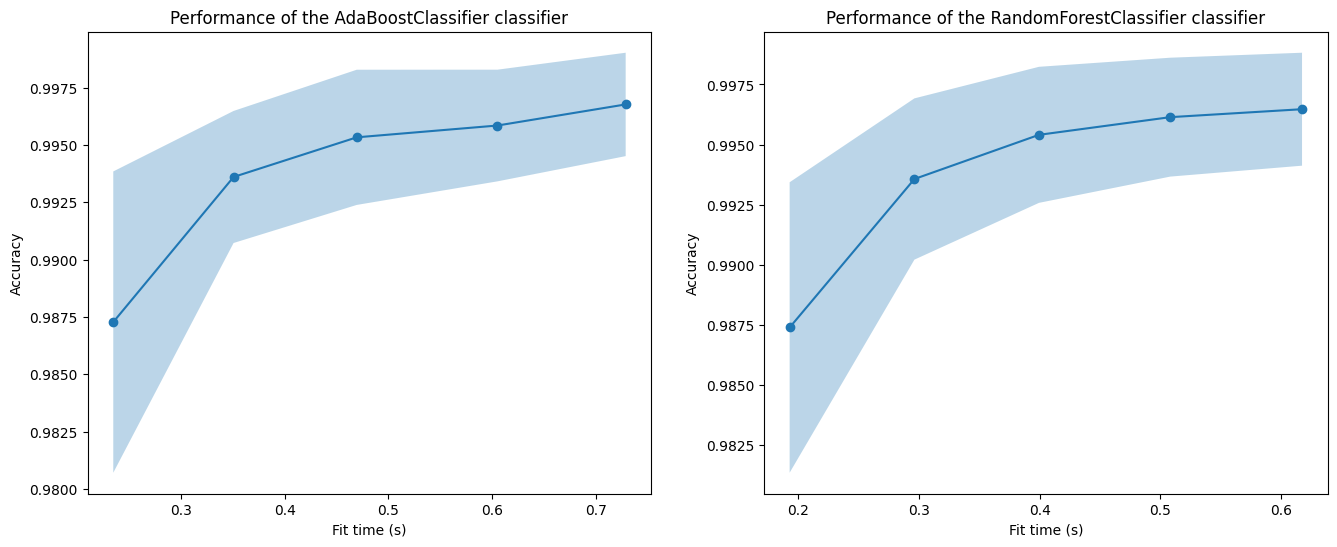

In [29]:
X = pd.read_csv('../body_level_classification_train.csv')
X = AdaBoostPreprocessor(X).copy()
X = AdaBoostSMOTE(X).copy()

y=X['Body_Level'].copy()
X.drop(columns=['Body_Level'], inplace=True)
with open('../models/model.pkl', 'rb') as f:
  models= pickle.load(f)
  ssc = models[0]
  ada = models[1]


common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "return_times": True,
}

train_sizes, _, test_scores_ada, fit_times_ada, score_times_ada = learning_curve(
    ada, **common_params
)
train_sizes, _, test_scores_RF, fit_times_RF, score_times_RF = learning_curve(
    RF_fin, **common_params
)









fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for ax_idx, (fit_times, test_scores, estimator) in enumerate(
    zip(
        [fit_times_ada, fit_times_RF],
        [test_scores_ada, test_scores_RF],
        [ada, RF_fin],
    )
):
    ax[ax_idx].plot(fit_times.mean(axis=1), test_scores.mean(axis=1), "o-")
    ax[ax_idx].fill_between(
        fit_times.mean(axis=1),
        test_scores.mean(axis=1) - test_scores.std(axis=1),
        test_scores.mean(axis=1) + test_scores.std(axis=1),
        alpha=0.3,
    )
    ax[ax_idx].set_ylabel("Accuracy")
    ax[ax_idx].set_xlabel("Fit time (s)")
    ax[ax_idx].set_title(
        f"Performance of the {estimator.__class__.__name__} classifier"
    )

plt.show()

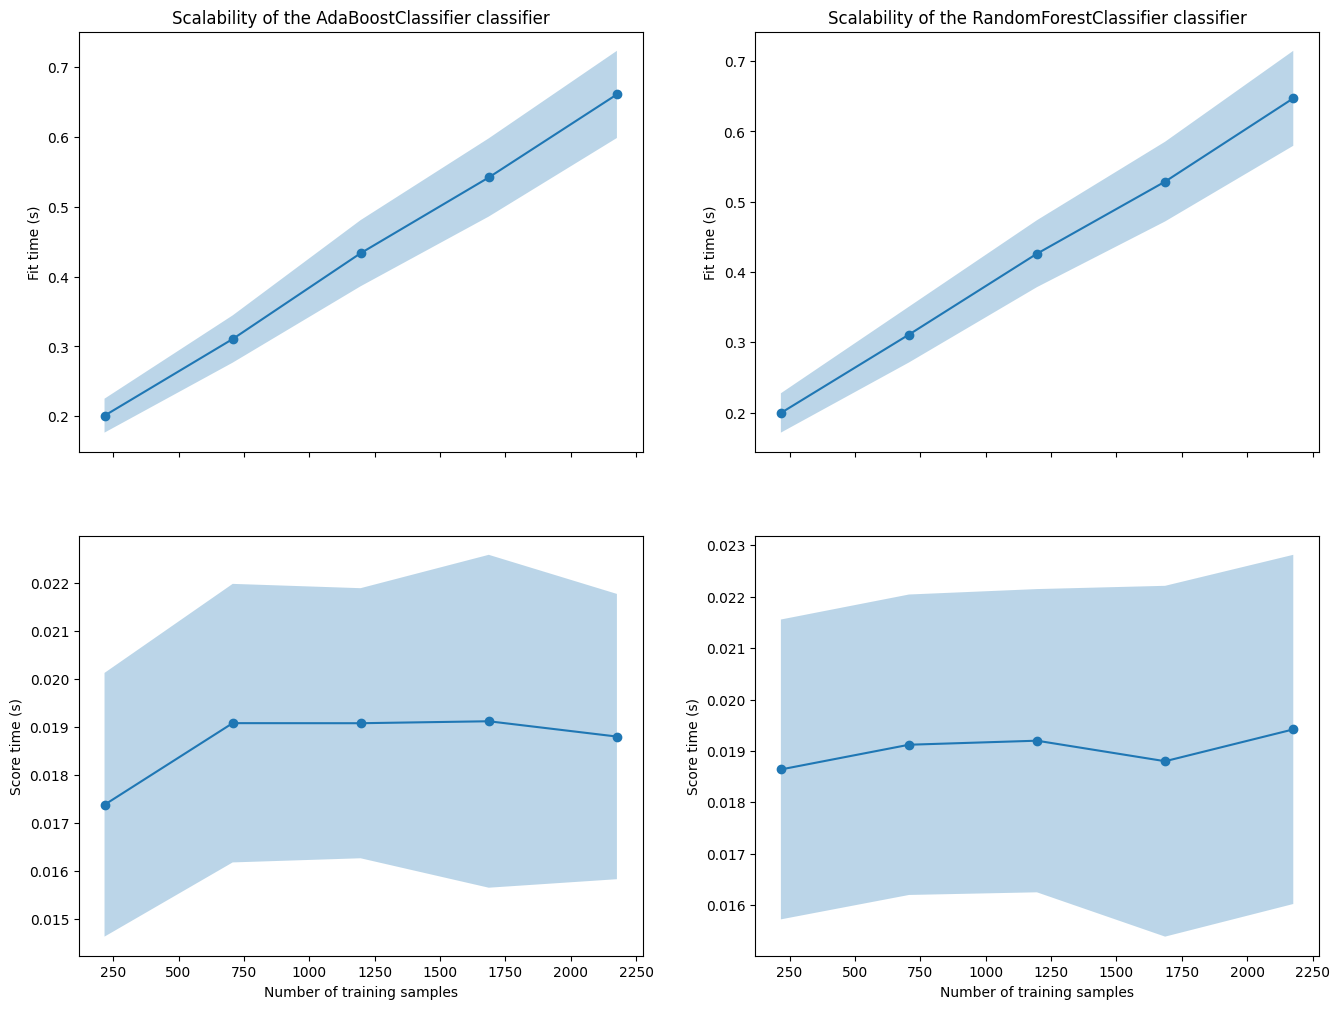

In [30]:

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "return_times": True,
}

train_sizes, _, test_scores_ada, fit_times_ada, score_times_ada = learning_curve(
    ada, **common_params
)
train_sizes, _, test_scores_RF, fit_times_RF, score_times_RF = learning_curve(
    RF_fin, **common_params
)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharex=True)

for ax_idx, (fit_times, score_times, estimator) in enumerate(
    zip(
        [fit_times_ada, fit_times_RF],
        [score_times_ada, score_times_RF],
        [ada, RF_fin],
    )
):
    # scalability regarding the fit time
    ax[0, ax_idx].plot(train_sizes, fit_times.mean(axis=1), "o-")
    ax[0, ax_idx].fill_between(
        train_sizes,
        fit_times.mean(axis=1) - fit_times.std(axis=1),
        fit_times.mean(axis=1) + fit_times.std(axis=1),
        alpha=0.3,
    )
    ax[0, ax_idx].set_ylabel("Fit time (s)")
    ax[0, ax_idx].set_title(
        f"Scalability of the {estimator.__class__.__name__} classifier"
    )

    # scalability regarding the score time
    ax[1, ax_idx].plot(train_sizes, score_times.mean(axis=1), "o-")
    ax[1, ax_idx].fill_between(
        train_sizes,
        score_times.mean(axis=1) - score_times.std(axis=1),
        score_times.mean(axis=1) + score_times.std(axis=1),
        alpha=0.3,
    )
    ax[1, ax_idx].set_ylabel("Score time (s)")
    ax[1, ax_idx].set_xlabel("Number of training samples")

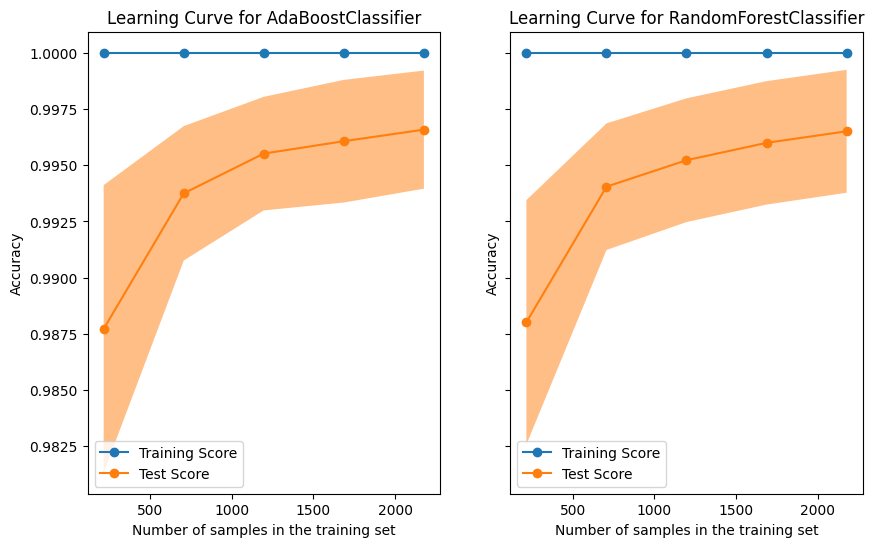

In [31]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([ada, RF_fin]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

### We will repeat the same learning curves but to compare a weak model to our strongest model

### Lets make a weak KNN model on our dataset without good preprocessing

In [32]:
NB_X = pd.read_csv('../body_level_classification_train.csv')
for i in NB_X.columns:
    NB_X[i].fillna(NB_X[i].mode()[0], inplace=True)
NB_X = AdaBoostPreprocessor(NB_X, False, False)
Y = NB_X['Body_Level']
NB_X.drop(columns=['Body_Level'])

NB_X_train, NB_X_test, NB_y_train, NB_y_test = train_test_split(NB_X, Y, test_size=0.3)


KNN_model = KNeighborsClassifier(n_neighbors=2)
y_pred = KNN_model.fit(NB_X_train, NB_y_train).predict(NB_X_test)
#print("Number of mislabeled points out of a total %d points : %d" % (NB_X_test.shape[0], (NB_y_test != y_pred).sum()))
print(classification_report(NB_y_test, y_pred))


              precision    recall  f1-score   support

           1       0.82      1.00      0.90        61
           2       0.75      0.57      0.65        63
           3       0.85      0.87      0.86       121
           4       0.98      0.97      0.98       199

    accuracy                           0.89       444
   macro avg       0.85      0.85      0.85       444
weighted avg       0.89      0.89      0.89       444



### now let's compare our weak knn model to the strong Adaboosted RF

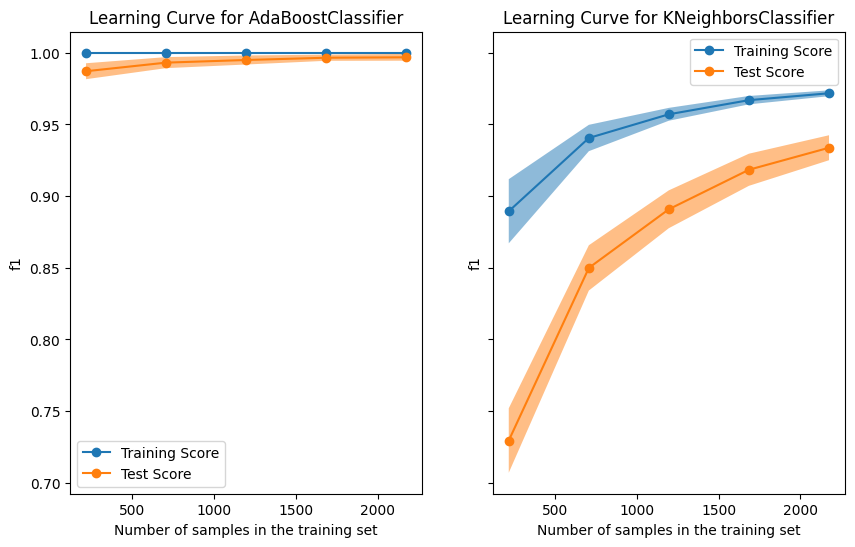

In [33]:
X = pd.read_csv('../body_level_classification_train.csv')
with open('../models/model.pkl', 'rb') as f:
  models= pickle.load(f)
  ssc = models[0]
  ada = models[1]


X = AdaBoostPreprocessor(X).copy()
X = AdaBoostSMOTE(X).copy()
y=X['Body_Level'].copy()
X.drop(columns=['Body_Level'], inplace=True)


X = ssc.transform(X).copy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f1",
}

for ax_idx, estimator in enumerate([ada, KNN_model]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

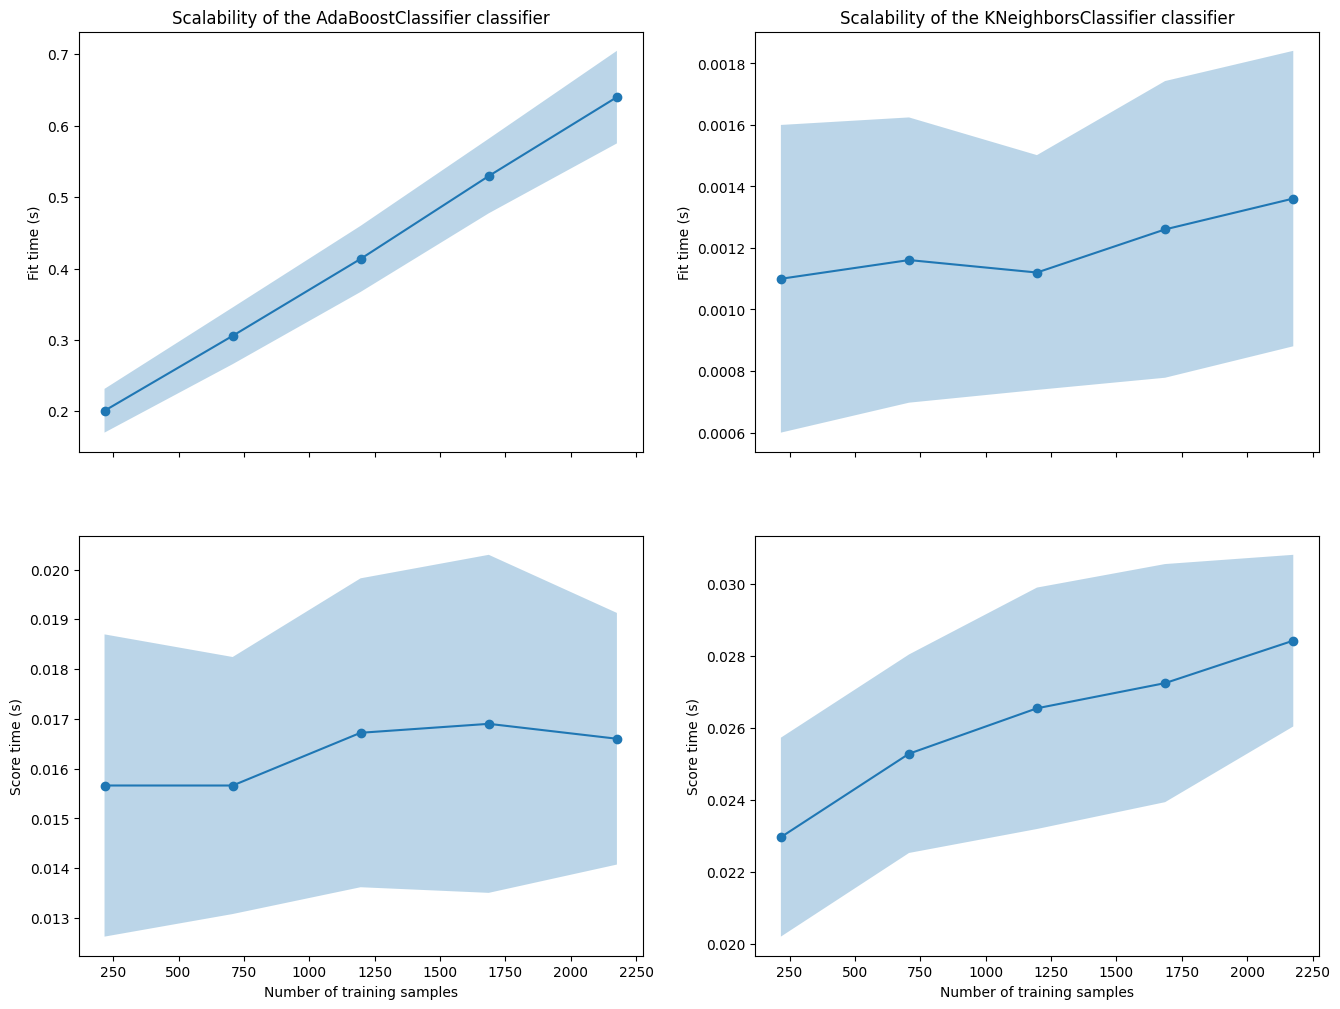

In [34]:

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "return_times": True,
}

train_sizes, _, test_scores_ada, fit_times_ada, score_times_ada = learning_curve(
    ada, **common_params
)
train_sizes, _, test_scores_RF, fit_times_RF, score_times_RF = learning_curve(
    KNN_model, **common_params
)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharex=True)

for ax_idx, (fit_times, score_times, estimator) in enumerate(
    zip(
        [fit_times_ada, fit_times_RF],
        [score_times_ada, score_times_RF],
        [ada, KNN_model],
    )
):
    # scalability regarding the fit time
    ax[0, ax_idx].plot(train_sizes, fit_times.mean(axis=1), "o-")
    ax[0, ax_idx].fill_between(
        train_sizes,
        fit_times.mean(axis=1) - fit_times.std(axis=1),
        fit_times.mean(axis=1) + fit_times.std(axis=1),
        alpha=0.3,
    )
    ax[0, ax_idx].set_ylabel("Fit time (s)")
    ax[0, ax_idx].set_title(
        f"Scalability of the {estimator.__class__.__name__} classifier"
    )

    # scalability regarding the score time
    ax[1, ax_idx].plot(train_sizes, score_times.mean(axis=1), "o-")
    ax[1, ax_idx].fill_between(
        train_sizes,
        score_times.mean(axis=1) - score_times.std(axis=1),
        score_times.mean(axis=1) + score_times.std(axis=1),
        alpha=0.3,
    )
    ax[1, ax_idx].set_ylabel("Score time (s)")
    ax[1, ax_idx].set_xlabel("Number of training samples")

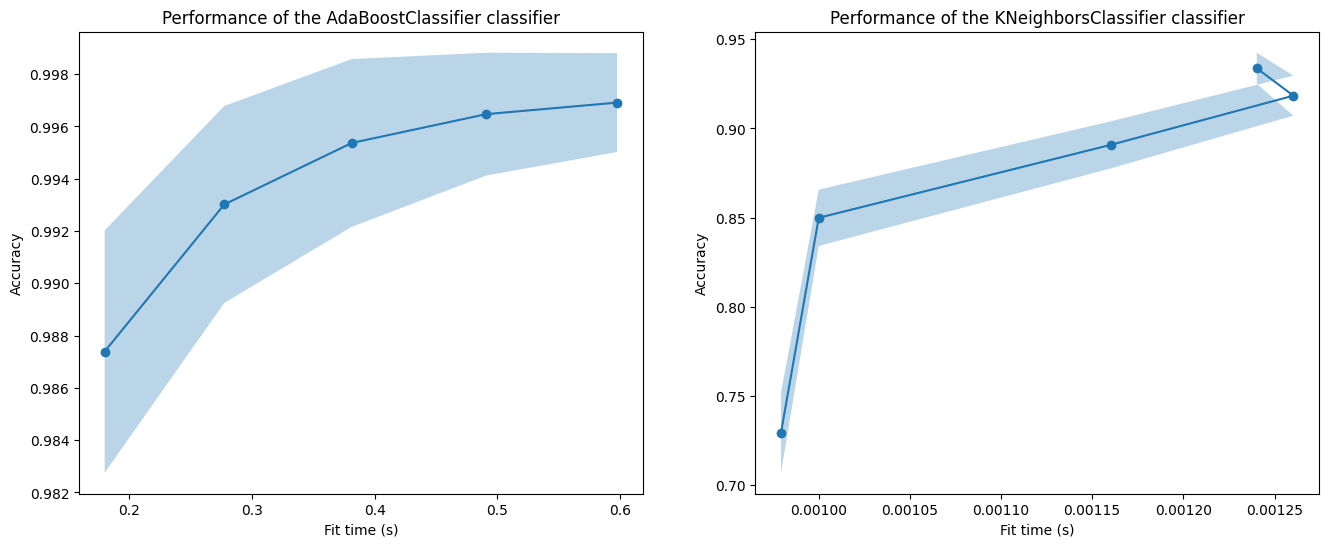

In [35]:

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "return_times": True,
}

train_sizes, _, test_scores_ada, fit_times_ada, score_times_ada = learning_curve(
    ada, **common_params
)
train_sizes, _, test_scores_RF, fit_times_RF, score_times_RF = learning_curve(
    KNN_model, **common_params
)









fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for ax_idx, (fit_times, test_scores, estimator) in enumerate(
    zip(
        [fit_times_ada, fit_times_RF],
        [test_scores_ada, test_scores_RF],
        [ada, KNN_model],
    )
):
    ax[ax_idx].plot(fit_times.mean(axis=1), test_scores.mean(axis=1), "o-")
    ax[ax_idx].fill_between(
        fit_times.mean(axis=1),
        test_scores.mean(axis=1) - test_scores.std(axis=1),
        test_scores.mean(axis=1) + test_scores.std(axis=1),
        alpha=0.3,
    )
    ax[ax_idx].set_ylabel("Accuracy")
    ax[ax_idx].set_xlabel("Fit time (s)")
    ax[ax_idx].set_title(
        f"Performance of the {estimator.__class__.__name__} classifier"
    )

plt.show()